Dans ce exercice qui est noté, vous allez:
* definir votre modèle de CNN
* sauvegarder un modèle entrainer et le charger pour l'utiliser
* explorer la notion de transfer learning

Il est conseillé d'exécuter ce code sur votre machine pour voir dans quel répertoire votre modèle est enrégistré.

***
**Charger les librairies**

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers, datasets, Input
from tensorflow.keras.utils import to_categorical

import matplotlib .pyplot as plt
import cv2 #opencv pour manipuler les images (une librairie très utile pour le traitement d'iamge)
import numpy as np
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

# Obtenir le nom du GPU
device_name = tf.test.gpu_device_name()
print(device_name)

#with tf.device('/device:GPU:0')...

***
**Charger le jeu de données CIFAR.** (Pour comprendre plus sur ces données veillez visiter ce lien: https://www.cs.toronto.edu/~kriz/cifar.html)

In [2]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
img_size = train_images.shape[1:4]
train_images.shape
IMG_SHAPE = (32, 32, 3)
#plt.imshow(test_images[1,:,:,:])

# Normaliser les valeurs des pixels pour qu'elles soient comprises entre 0 et 1
train_images, test_images = train_images / 255.0, test_images / 255.0

# Ceci est juste pour nous aider à associer une valeur numérique à chaque classe. Par exemple, la valeur d'indice 0 correspond à la classe avion.
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step


***
**Nous commençons par entrainer un modèle totalement défini par nous-mêmes**

In [3]:
# Nous definissons une fonction qui entraine le modèle en s'assurant que le GPU est utilisé

def train_net(net_func, num_epochs, lr, batch_size, gpu_device_name, train_images, train_labels):
  # net_func: la fonction qui retourne le model
  # num_epochs: nombre d'époques
  # lr: taux d'apprentissage
  # gpu_device_name: le nom du GPU utilisé

  # Nous definissons l'entrainement de sorte qu'il utilise le GPU
  # L'algorithme d'optimisation et la fonction de coût sont aussi définie.
  strategy = tf.distribute.OneDeviceStrategy(gpu_device_name)
  with strategy.scope():
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
    loss = tf.keras.losses.CategoricalCrossentropy()
    net = net_func()
    net.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

  history=net.fit(train_images, to_categorical(train_labels), batch_size=batch_size,epochs=num_epochs, verbose=1)
  return net, history # Le modèle entrainé est retourné en plus de l'historique de l'entrainement.

***
**Entraînez le modèle suivant pendant quelques minutes:**
Ce réseau est le réseau **LeNet**.

In [4]:
# Nous définissons une fonction dans laquelle nous définissons l'architecture de notre modèle. La fonction renvoie le modèle

def network():
  model = models.Sequential();
  model.add(layers.Conv2D(input_shape=img_size, filters=6, kernel_size=5, padding="same", activation="sigmoid"))
  model.add(layers.AvgPool2D(pool_size=2, strides=2))
  model.add(layers.Conv2D(filters=16, kernel_size=5, activation='sigmoid'))
  model.add(layers.AvgPool2D(pool_size=2, strides= 2))
  model.add(layers.Flatten())
  model.add(layers.Dense(120, activation="sigmoid"))
  model.add(layers.Dense(84, activation="sigmoid"))
  model.add(layers.Dense(10, activation='softmax'))
  return model



# ****************NOTE: CELA VA PRENDRE DU TEMPS********************************
### Entraînement du réseau à l'aide de notre fonction "train_net" définie précédemment
#****TACHE 1.1: entrainer au moins pendant 100 epochs
#****TACHE REPORTING 1.1: ajouter l'image de la courbe de fonction de coût dans votre rapport.
lr = 0.4
epochs = 100
batch_size = 256 # réduire le batch size au bésoin(selon la performance de votre machine)
trained_net, history= train_net(network, epochs, lr, batch_size, device_name, train_images, train_labels) # Training the network
plt.plot(history.history['loss'])

# Sauvegarder les poids du réseau entrainé.
trained_net.save("traine_net.h5")



/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
 28/196 ━━━━━━━━━━━━━━━━━━━━ 54s 324ms/step - accuracy: 0.1024 - loss: 2.3396

KeyboardInterrupt: 

***
**Tester le modèle**

312/312 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5782 - loss: 1.2284
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
The image is a:  dog
The model predicted a:  dog


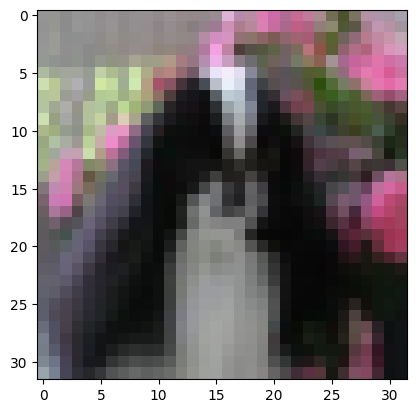

In [ ]:
# Évaluez le modèle sur l'ensemble de données de test (vous verrez la valeur de la fonction de perte et la précision).
results = trained_net.evaluate(test_images[0:9984,:,:,:],to_categorical(test_labels[0:9984,:]))


# Nous définissons une fonction pour comparer la prédiction du modèle avec l'étiquette réelle
def model_predict(model, img, true_label):
  img = np.expand_dims(img, axis=0) # image size from (32,32,3) to (1, 32, 32, 3)
  y = model.predict(img)
  y_hat = np.argmax(y)
  print("The image is a: ", class_names[true_label[0]])
  print("The model predicted a: ", class_names[y_hat])


# Tester le modèle sur une image en utilisant la fonction "model_predict" définie précédemment
im_ind = 42 # Changer l'index de l'image pour une autre image
model_predict(trained_net, test_images[im_ind,:,:,:], test_labels[im_ind])
plt.imshow(test_images[im_ind,:,:,:])



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step
The image is a:  cat
The model predicted a:  dog


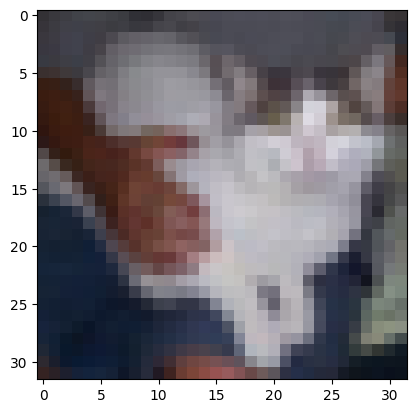

In [ ]:
# Charger le modèle enrégistré
mon_modele_charger = models.load_model("traine_net.h5")

# utiliser le modèle charger dans la fonction de prediction que nous avons definie plus haut.
# L'idée est que ce modèle recharger se comporte exactement comme le modèle entrainé car il s'agit du même modèle qui a été sauvegardé et rechargé.
im_ind = 77 # Changer l'index de l'image pour une autre image
model_predict(mon_modele_charger, test_images[im_ind,:,:,:], test_labels[im_ind]) # nous avons changé le nom du modèle en argument
plt.imshow(test_images[im_ind,:,:,:])


In [ ]:
mon_modele_charger.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 6)      │           456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 16, 16, 6)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 12, 12, 16)     │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 6, 6, 16)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 120)            │        69,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,128 (324.72 KB)

 Trainable params: 83,126 (324.71 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

***
** Construire un modèle plus performant que le modèle qui vous a été donné. Ceci est un processus itératif. Vous devez définir un modèle, l'entrainer, voir ses performances, l'ajuster et le ré-entrainer, et ainsi de suite jusqu'à avoir une performance satisfaisante.

Vous pouvez utiliser des notion de:  
* batch normalization
* dropout
* changer le kernel size le nombre de filtres
* changer le nombre de couches à convolution
* utiliser différentes fonctions d'activation
* la taille de vos couches totalelement connectées
* utiliser differentes méthode d'optimisation

**NOTE:** la méthode d'optimisation doit être définie dans la fonction **train_net** que j'ai reproduit ci-dessous au cas ou vous souhaitez changer la méthode d'optimisation.

In [ ]:
def train_net_2(net_func, num_epochs, lr, batch_size, gpu_device_name, train_images, train_labels):
  # net_func: la fonction qui retourne le model
  # num_epochs: nombre d'époques
  # lr: taux d'apprentissage
  # gpu_device_name: le nom du GPU utilisé

  # Nous definissons l'entrainement de sorte qu'il utilise le GPU
  # L'algorithme d'optimisation et la fonction de coût sont aussi définie.
  strategy = tf.distribute.OneDeviceStrategy(gpu_device_name)
  with strategy.scope():
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr) # j'utilise l'optimisateur Adam, souvent plus performant
    loss = tf.keras.losses.CategoricalCrossentropy()
    net = net_func()
    net.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

  history=net.fit(train_images, to_categorical(train_labels), batch_size=batch_size,epochs=num_epochs, verbose=1)
  return net, history # Le modèle entrainé est retourné en plus de l'historique de l'entrainement.

In [ ]:
# Creer un modèle plus performant que le modèle qui vous a été donné précédemment

# TACHE 1.2: VOTRE CODE ICI
# TACHE REPORTING 1.2: Pourquoi avez vous choisie une telle architecture?


def mon_model_2():
  model = models.Sequential()

  # 1ere couche de convolution avec ReLU et Batch Normalization
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
  model.add(layers.BatchNormalization())

  # 2e couche de convolution avec ReLU et Batch Normalization
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.25))

  # 3e couche
  model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
  model.add(layers.BatchNormalization())

  # 4e couche
  model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.25))

  # les couches denses
  model.add(layers.Flatten())
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(10, activation='softmax'))

  return model

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.4228 - loss: 1.8492
Epoch 2/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 0.6498 - loss: 0.9970
Epoch 3/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.7010 - loss: 0.8454
Epoch 4/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 0.7370 - loss: 0.7515
Epoch 5/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.7593 - loss: 0.6835
Epoch 6/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.7849 - loss: 0.6105
Epoch 7/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.8033 - loss: 0.5581
Epoch 8/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.8209 - loss: 0.5094
Epoch 9/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.8282 - loss: 0.4762
Epoch 10/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 0.8466 - loss: 0.4318
Epoch 11/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 0.8549 - loss: 0.4068
Epoch 12/100
782/78

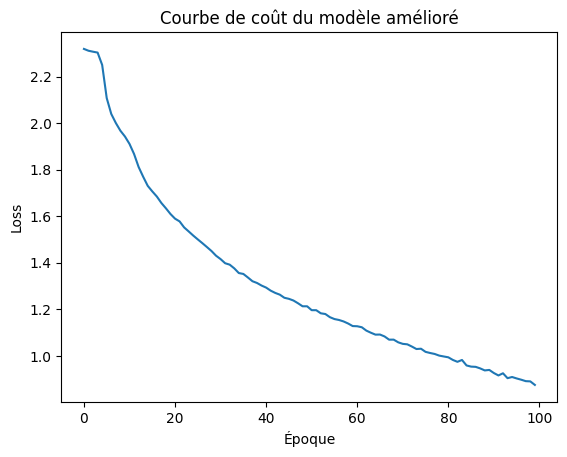

In [ ]:
# Entrainer le modèle que vous venez de créer.
# TACHE: VOTRE CODE ICI

# Entrainement de mon_model_2
lr = 0.001  # le learning rate est plus faible ici pour l'optimisateur Adam
epochs = 100
batch_size = 64 # la taille du batch est réduit également
trained_net_2, history_2= train_net_2(mon_model_2, epochs, lr, batch_size, device_name, train_images, train_labels)

# Affichage de la courbe de fonction de coût
plt.plot(history.history['loss'])
plt.title('Courbe de coût du modèle amélioré')
plt.ylabel('Loss')
plt.xlabel('Époque')
plt.show()

trained_net_2.save("modele2.keras")

In [ ]:
mon_modele_charger_2 = models.load_model("modele2.keras")
mon_modele_charger_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,510,720 (24.84 MB)

 Trainable params: 2,169,770 (8.28 MB)

 Non-trainable params: 1,408 (5.50 KB)

 Optimizer params: 4,339,542 (16.55 MB)

In [ ]:
# Evaluer le modèle sur les données de teste.
# TACHE 1.3: Evaluer le modèle sur les données de test et les données d'entrainement
# TACHE REPORTING: 1.3: Ajouter les valeurs de performance dans votre rapport et argumenter pourquoi votre modèle depasse le modèle précédent?
# VOTRE CODE ICI

# Évaluation sur les données d'entraînement
train_results = trained_net_2.evaluate(train_images, to_categorical(train_labels), verbose=1)
print("\nPerformance sur les données d'entraînement :")
print(f"Loss : {train_results[0]:.4f}")
print(f"Accuracy : {train_results[1]:.4f}")

# Évaluation sur les données de test
test_results = trained_net_2.evaluate(test_images, to_categorical(test_labels), verbose=1)
print("\nPerformance sur les données de test :")
print(f"Loss : {test_results[0]:.4f}")
print(f"Accuracy : {test_results[1]:.4f}")


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 1.0000 - loss: 7.6802e-04

Performance sur les données d'entraînement :
Loss : 0.0008
Accuracy : 1.0000
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8405 - loss: 0.7175

Performance sur les données de test :
Loss : 0.7114
Accuracy : 0.8403


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
The image is a:  cat
The model predicted a:  cat


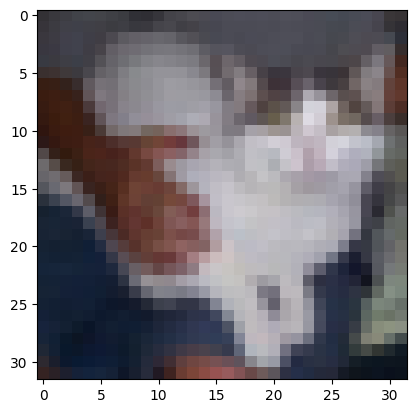

In [ ]:

# Tester le modèle sur une image de test en utilisant la fonction "model_predict" définie précédemment
im_ind = 77 # Changer l'index de l'image pour une autre image
model_predict(trained_net_2, test_images[im_ind,:,:,:], test_labels[im_ind])
plt.imshow(test_images[im_ind,:,:,:])

***
***

**Nous allons explorer la notion de Transfer Learning ici**



***

**Charger le modèle VGG16** et retirez la partie fully connected. Nous gardons seulement le backbone (les couches à convolution).
Notez que nous avons importé le modèle dans la partie d'importation des librairies plus haut. Nous avons choisi VGG16 ici car il est assez petit comparé aux autres modèles pré-entraînés disponibles dans **keras**.

In [5]:
# Juste une repetition de la fonction que nous utilisons pour entrainer un modèle.
def train_net(net_func, num_epochs, lr, batch_size, gpu_device_name, train_images, train_labels):
  # net_func: la fonction qui retourne le model
  # num_epochs: nombre d'époques
  # lr: taux d'apprentissage
  # gpu_device_name: le nom du GPU utilisé

  # Nous definissons l'entrainement de sorte qu'il utilise le GPU
  # L'algorithme d'optimisation et la fonction de coût sont aussi définie.
  strategy = tf.distribute.OneDeviceStrategy(gpu_device_name)
  with strategy.scope():
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr) # la méthode d'optimisation
    loss = tf.keras.losses.CategoricalCrossentropy()
    net = net_func()
    net.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

  history=net.fit(train_images, to_categorical(train_labels), batch_size=batch_size,epochs=num_epochs, verbose=1)
  return net, history # Le modèle entrainé est retourné en plus de l'historique de l'entrainement.

In [6]:
# Une fonction qui retourne un model composé du partie qui est déjà entrainée et nouvelle partie que nous definissons et qui sera affiner durant l'entrainement
def myVGG16():
  # Nous chargeons le VGG sans la couche entièrement connectée. Nous adaptons la taille de la couche d'entrée à la taille de nos images.
  base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
  # Rendre les couches du VGG16 "frozen" (non entrainables)
  base_model.trainable = False
  # Nous definissons un nouveau model avec VGG16 placé au debut.
  model = models.Sequential([
      base_model,
      layers.Flatten(),
      layers.Dense(256, activation='relu'),
      layers.Dropout(0.5),
      layers.Dense(10, activation='softmax')  # le nombre de neurones ici corresponds au nombre de classes
  ])
  return model


In [ ]:
# Entrainer le modèle que vous venez de créer
lr = 0.001
epochs = 100
batch_size = 256 # réduire le batch size au bésoin(selon la performance de votre machine)
# Nous utilisons la même fonction "train_net" definie précédemment pour entrainer le modèle. Veuillez vous assurer que vous comprenez les arguments que recoive cette fonction.
# Remonter dans la partie ou la fonction
trained_vgg, hist= train_net(myVGG16, num_epochs=epochs, lr=lr, batch_size=batch_size, gpu_device_name=device_name, train_images=train_images, train_labels=train_labels)

***
**Evaluer et tester le modèle**


In [ ]:
results = trained_vgg.evaluate(test_images, test_labels)


im_ind = 110 # Changer l'index de l'image pour une autre image
img = test_images[im_ind, :, :]
label= test_labels[im_ind, :]
model_predict(trained_vgg, img, label)
plt.imshow(img)

313/313 [==============================] - 3s 10ms/step - loss: 2.3026 - accuracy: 0.1000
The image is a:  deer
The model predicted a:  bird


***
**Reprenez la definition du modèle du VGG ou un autre modèle CNN préntraîné comme fait précédemment.
Modifier la Partie entièrement connectée du réseau CNN
Pouvez-vous obtenir un meilleur résultat ?
Essayez de rendre la dernière couche à convolution entrainable (ne pas geler la dernière couche à convolution). Pouvez vous observez une amélioration?**

In [ ]:
def newModel():
  # TACHE 1.4: VOTRE CODE ICI. Reproduire le modèle créer dans la fonction "myVGG16()" ou choisir un autre modèle préntraîner. Modifier la partie fully connected pour avoir une meilleure performance
  # TACHE REPORTING 1.4: Après entrainement, ajouter dans votre rapport la figure de lévolution de la fonction de coût.









In [ ]:
# Entrainer le modèle que vous venez de créer
lr = 0.7 # Vous pouvez changer le taux d'apprentissage
epochs = 100
batch_size = 256

# Nous utilisons la même fonction "train_net" definie précédemment pour entrainer le modèle. Veuillez vous assurer que vous comprenez les arguments que recoive cette fonction.
# Remonter dans la partie ou la fonction
trained_vgg, hist= train_net(newModel, num_epochs=epochs, lr=lr, batch_size=batch_size, gpu_device_name=device_name, train_images=train_images, train_labels=train_labels)

In [ ]:
def newModel_1():
  # TACHE 1.5: VOTRE CODE ICI. Reproduire le modèle créer dans la tache précédente. Rendre la dernière couche à convulion entrainable (geler toutes les autres couches à convolution sauf la dernière couche à convolution)
  # TACHE REPORTING 1.5: Après entrainement, ajouter dans votre rapport la figure de lévolution de la fonction de coût. Y'a t-il une amélioration de la performance du modèle?


In [ ]:
# Entrainer le modèle que vous venez de créer
lr = 0.7 # Vous pouvez changer le taux d'apprentissage
epochs = 100
batch_size = 256

# Nous utilisons la même fonction "train_net" definie précédemment pour entrainer le modèle. Veuillez vous assurer que vous comprenez les arguments que recoive cette fonction.
# Remonter dans la partie ou la fonction
# vous pouvez changer la méthode d'optimisation dans cette fonction "train_net".
trained_vgg, hist= train_net(newModel_1, num_epochs=epochs, lr=lr, batch_size=batch_size, gpu_device_name=device_name, train_images=train_images, train_labels=train_labels)

# **References**

Vous pouvez consulter ces references parmis tant d'autres pour plus d'informations.

* http://neuralnetworksanddeeplearning.com/
* https://d2l.ai/chapter_convolutional-neural-networks/
* https://keras.io/api/applications/